C:\Users\Luca\AppData\Local\Temp/ipykernel_19304/4103777069.py:29: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  input_image_grey = rgb2gray(input_image)


18.80921073911251
15.606329396783105


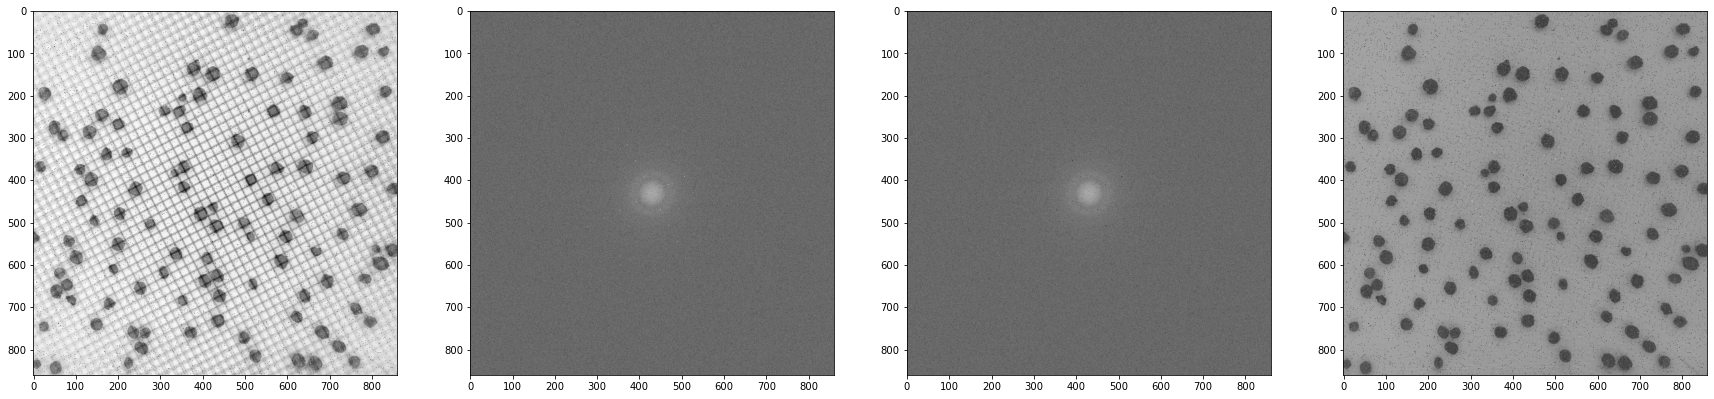

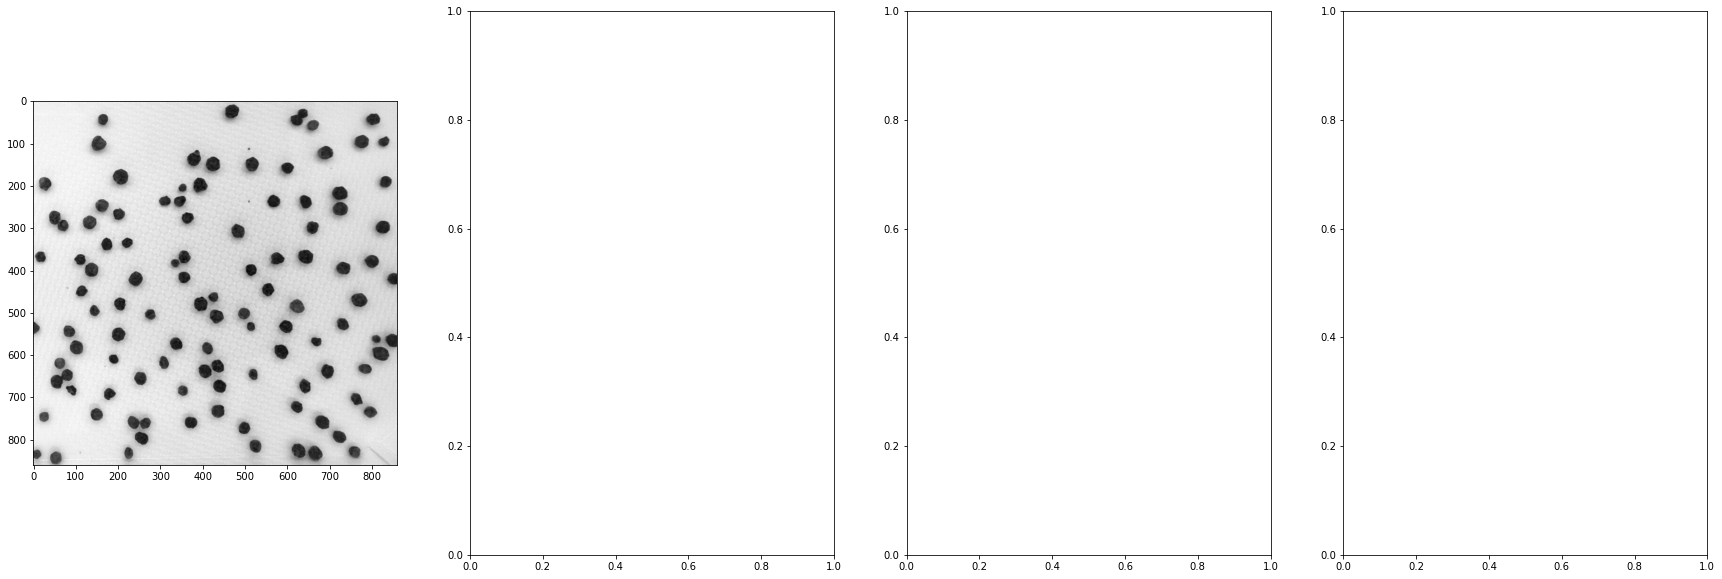

In [111]:
import numpy.fft
import numpy as np
import scipy.ndimage
from scipy import ndimage as ndim
import skimage.morphology
import skimage.io
from scipy.ndimage import median_filter
from skimage.morphology.selem import disk
from skimage import filters
# import skimage.measure.label
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
from skimage.feature import peak_local_max

plt.rcParams['image.cmap'] = 'gray'  # change default colormap

fig, ax = plt.subplots(ncols=4, figsize=(30,10))

# input_image = tifffile.imread('./img/input.tif')
input_image = skimage.io.imread("./img/input.tif")
# ax[0].imshow(input_image)

input_image_grey = rgb2gray(input_image)
ax[0].imshow(input_image_grey)
# fft
input_image_fft = np.fft.fftshift(np.fft.fft2(input_image_grey))
# ax[2].imshow(np.log(abs(input_image_fft)), cmap='gray')
ax[1].imshow(np.log(abs(input_image_fft)), cmap='gray')
radius = 12
center = 430
print(np.log(abs(input_image_fft.max())))
print(np.log(abs(input_image_fft.min())))
# print(np.log(abs(input_image_fft[430,430])))

input_image_fft_edit = input_image_fft
for x in range(int(np.sqrt(input_image_fft_edit.size))):
    for y in range(int(np.sqrt(input_image_fft_edit.size))):
        if ((x>center + radius or x<center - radius and (y > center + radius or y< center - radius)) 
            and (y > center + radius or y< center - radius and (x>center + radius or x<center - radius))):
            if (np.log(abs(input_image_fft_edit[x,y])) > 13.5):
                input_image_fft_edit[x,y] = np.complex128(255)

ax[2].imshow(np.log(abs(input_image_fft_edit)), cmap='gray')

input_image_ifft = abs(np.fft.ifft2(input_image_fft))
ax[3].imshow(input_image_ifft, cmap='gray')

fig, ax = plt.subplots(ncols=4, figsize=(30,10))

median_img = median_filter(input_image_ifft, 4)
ax[0].imshow(median_img)

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


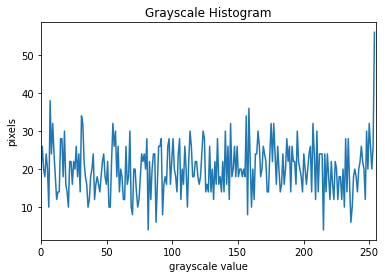

Threshold at: 161.3748673342388


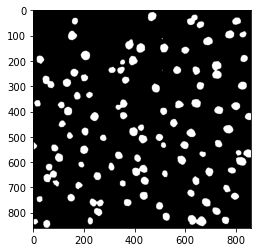

110


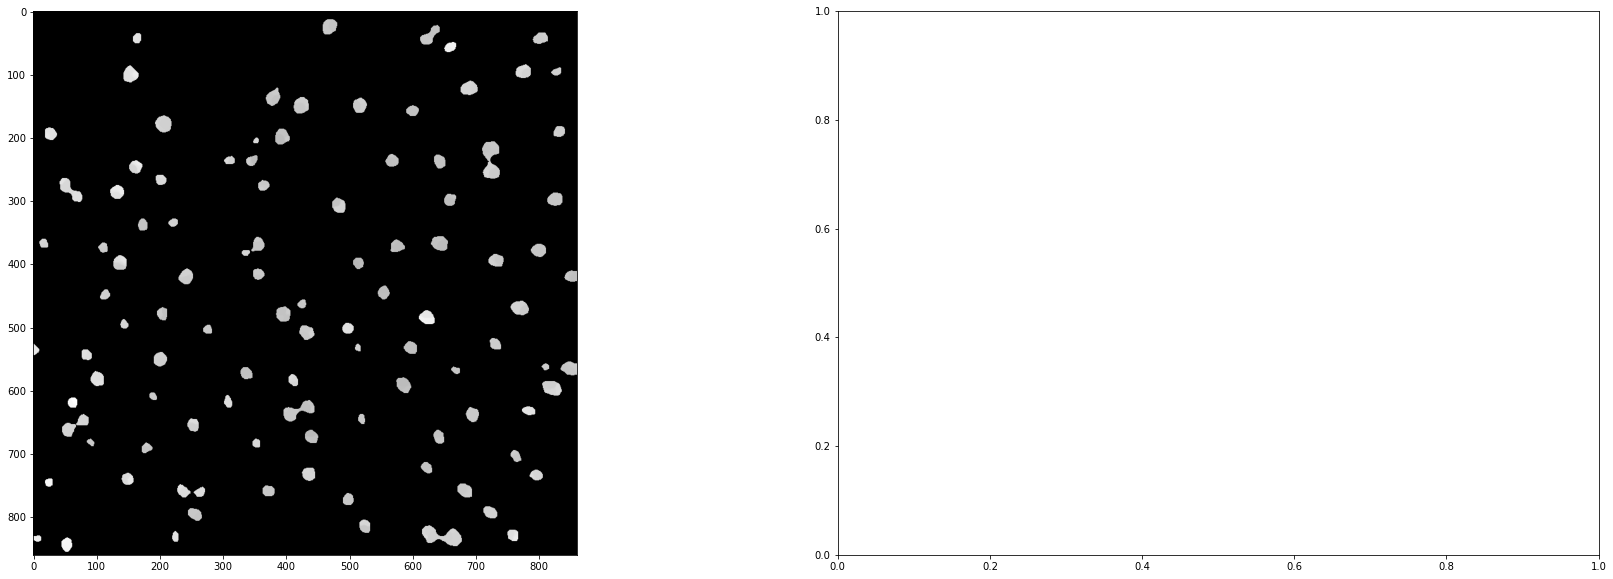

In [123]:
histogram, bin_edges = np.histogram(input_image_fft, bins=256, range=(0, 255))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 255)
plt.show()


t = filters.threshold_otsu(median_img)
print("Threshold at: {}".format(t))

binary_mask = median_img < t
fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap='gray')
plt.show()

# use the binary_mask to remove the background
masked_img = np.zeros_like(median_img)
masked_img[binary_mask] = median_img[binary_mask]

erosion_radius = 10.5

fig, ax = plt.subplots(ncols=2, figsize=(30,10))
erosion_img = skimage.morphology.dilation(masked_img, disk(erosion_radius/3))
erosion_img = skimage.morphology.erosion(erosion_img, disk(erosion_radius))
erosion_img = skimage.morphology.dilation(erosion_img, disk(erosion_radius/4))
ax[0].imshow(erosion_img)

min_d = 5

distance = ndim.distance_transform_edt(erosion_img)
coordinates = peak_local_max(distance, min_distance=min_d)
print(len(coordinates))